In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
import nltk

In [3]:
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
# df = df.head(200)

#### Shape

In [4]:
df.shape

(568454, 10)

In [5]:
df = df.head(500)

#### Basic EDA

In [6]:
df['Score'].value_counts()

5    339
4     70
3     37
1     36
2     18
Name: Score, dtype: int64

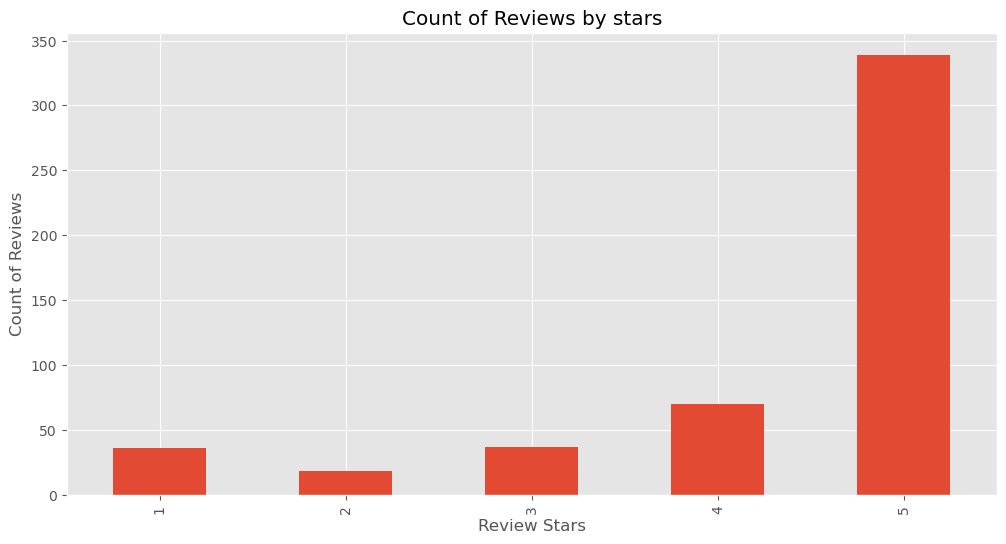

In [7]:
# Getting the score values in plot
axes = df['Score'].value_counts().sort_index().plot(kind = 'bar',
                                             title = "Count of Reviews by stars",
                                             figsize = (12,6))

axes.set_xlabel("Review Stars")
axes.set_ylabel("Count of Reviews")
plt.show()

In [8]:
# The data is biased a lot towards positive reviews

#### Basic NLTK

In [9]:
df.shape

(500, 10)

In [10]:
ex = df['Text'][50] #Checking Random value out of text column
ex

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [11]:
tokens = nltk.word_tokenize(ex)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [12]:
tagged = nltk.pos_tag(tokens[:10])
# Use NLTK's currently recommended part of speech tagger to
# tag the given list of tokens.
tagged

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [13]:

# Ex. of part of speech taggers:
    # Abbreviation         Meaning
    # CC                   coordinating conjunction   
    # CD                   cardinal digit
    # DT                   determiner 
    # EX                   existential there
    # FW                   foreign word
    # IN                   preposition/subordinating conjunction    
    # JJ                   This NLTK POS Tag is an adjective (large)
    # JJR                  adjective, comparative (larger)
    

In [14]:
entities = nltk.chunk.ne_chunk(tagged)
# Use NLTK's currently recommended named entity chunker to
# chunk the given list of tagged tokens.
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ)


### Step 1: VADER Sentiment Scoring

* We'll use NLTK's SentimentIntensityAnalyser to get -/+/Neutral scores of the text
* This uses bag of words approach
* Stop words are removed
* Each word is scored and combined to a total score

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [16]:
# This will gives compound values Return a float for sentiment strength based on the input text.
# Positive values are positive valence, negative value are negative
# valence.
sia.polarity_scores("I'm soo happy")


{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'compound': 0.5719}

In [17]:
sia.polarity_scores("this is worst !")

{'neg': 0.687, 'neu': 0.313, 'pos': 0.0, 'compound': -0.6588}

In [18]:
# Let's check for our example
sia.polarity_scores(ex)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [19]:
# Storing it
res = {}

# Running polarity on entire dataset
for i,row in tqdm(df.iterrows(),total= len(df)):
    text = row["Text"]
    my_id = row["Id"]
    res[my_id] = sia.polarity_scores(text)
    

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
# Storing this in Pandas Df
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns = {'index':"Id"})
vader = vader.merge(df, how = "left")

In [21]:
vader.head(5)
# Sentiment score and given data(MetaData)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Plot VADER Results

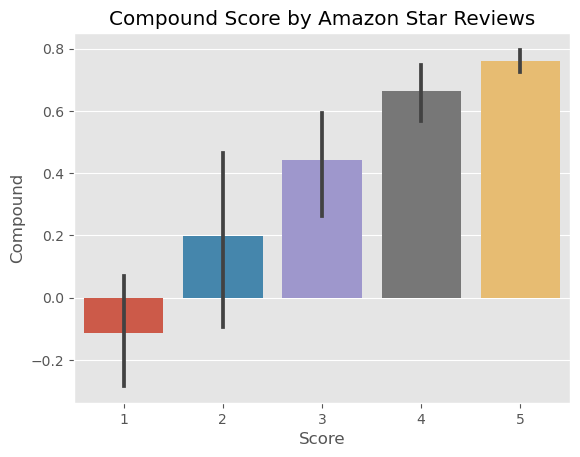

In [22]:
ax = sns.barplot(data = vader,x="Score",y="compound")
ax.set_title("Compound Score by Amazon Star Reviews")
ax.set_xlabel("Score")
ax.set_ylabel("Compound")
plt.show()

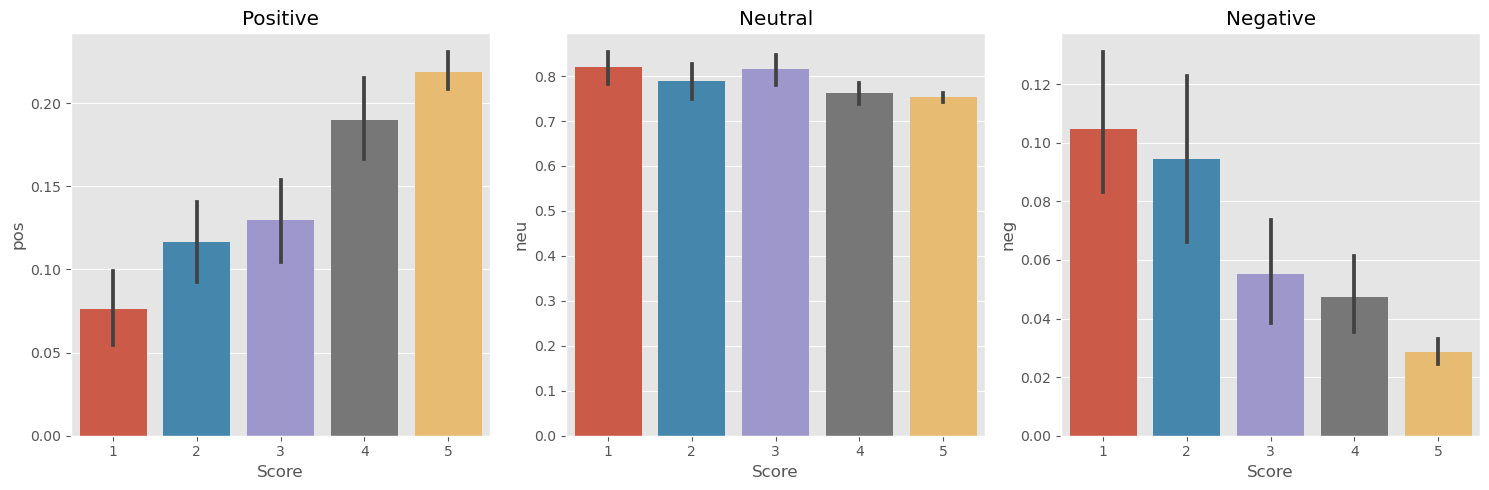

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vader, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vader, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vader, x='Score', y='neg', ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative" )
plt.tight_layout()
plt.show()

### Step 2: Roberta Pre-trained Model

* Use a model trained of a large corpus of data
* Transformer model accounts for the words but also the context related to other words

In [24]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

In [25]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# This will pull down the model 
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [26]:
# VADER Results on Example:
sia.polarity_scores(ex)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [27]:
# Run for roBERTa Model
encoded_text = tokenizer(ex,return_tensors = 'pt')
output = model(**encoded_text)

In [28]:
scores = output[0][0].detach().numpy()
# SToring the output in numpy array

scores = softmax(scores)
scores
scores_dict = {
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2],
}
print(scores_dict)

{'roberta_neg': 0.9763551, 'roberta_neu': 0.020687481, 'roberta_pos': 0.0029573701}


In [29]:
def pol_scores_roberta(ex): 
    # Run for roBERTa Model
    encoded_text = tokenizer(ex,return_tensors = 'pt')
    output = model(**encoded_text)    
    scores = output[0][0].detach().numpy()
    # SToring the output in numpy array

    scores = softmax(scores)
    scores
    scores_dict = {
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2],
    }
    return scores_dict

In [32]:
res = {}
for i,row in tqdm(df.iterrows(),total = len(df)):
    try:
        text = row["Text"]
        my_id = row["Id"]

        vader_result = sia.polarity_scores(text)        
        vader_result_rename = {}
        for k,v in vader_result.items():
            vader_result_rename[f"vader_{k}"] = v
        roberta_result = pol_scores_roberta(text)    
        both = {**vader_result_rename,**roberta_result}
        res[my_id] = both
    except RuntimeError:
        print(f"Broke for id {my_id}")

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [33]:
results_df = pd.DataFrame(res) .T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

### Compare Scores between models

In [34]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### Step 3: Combine And Compare

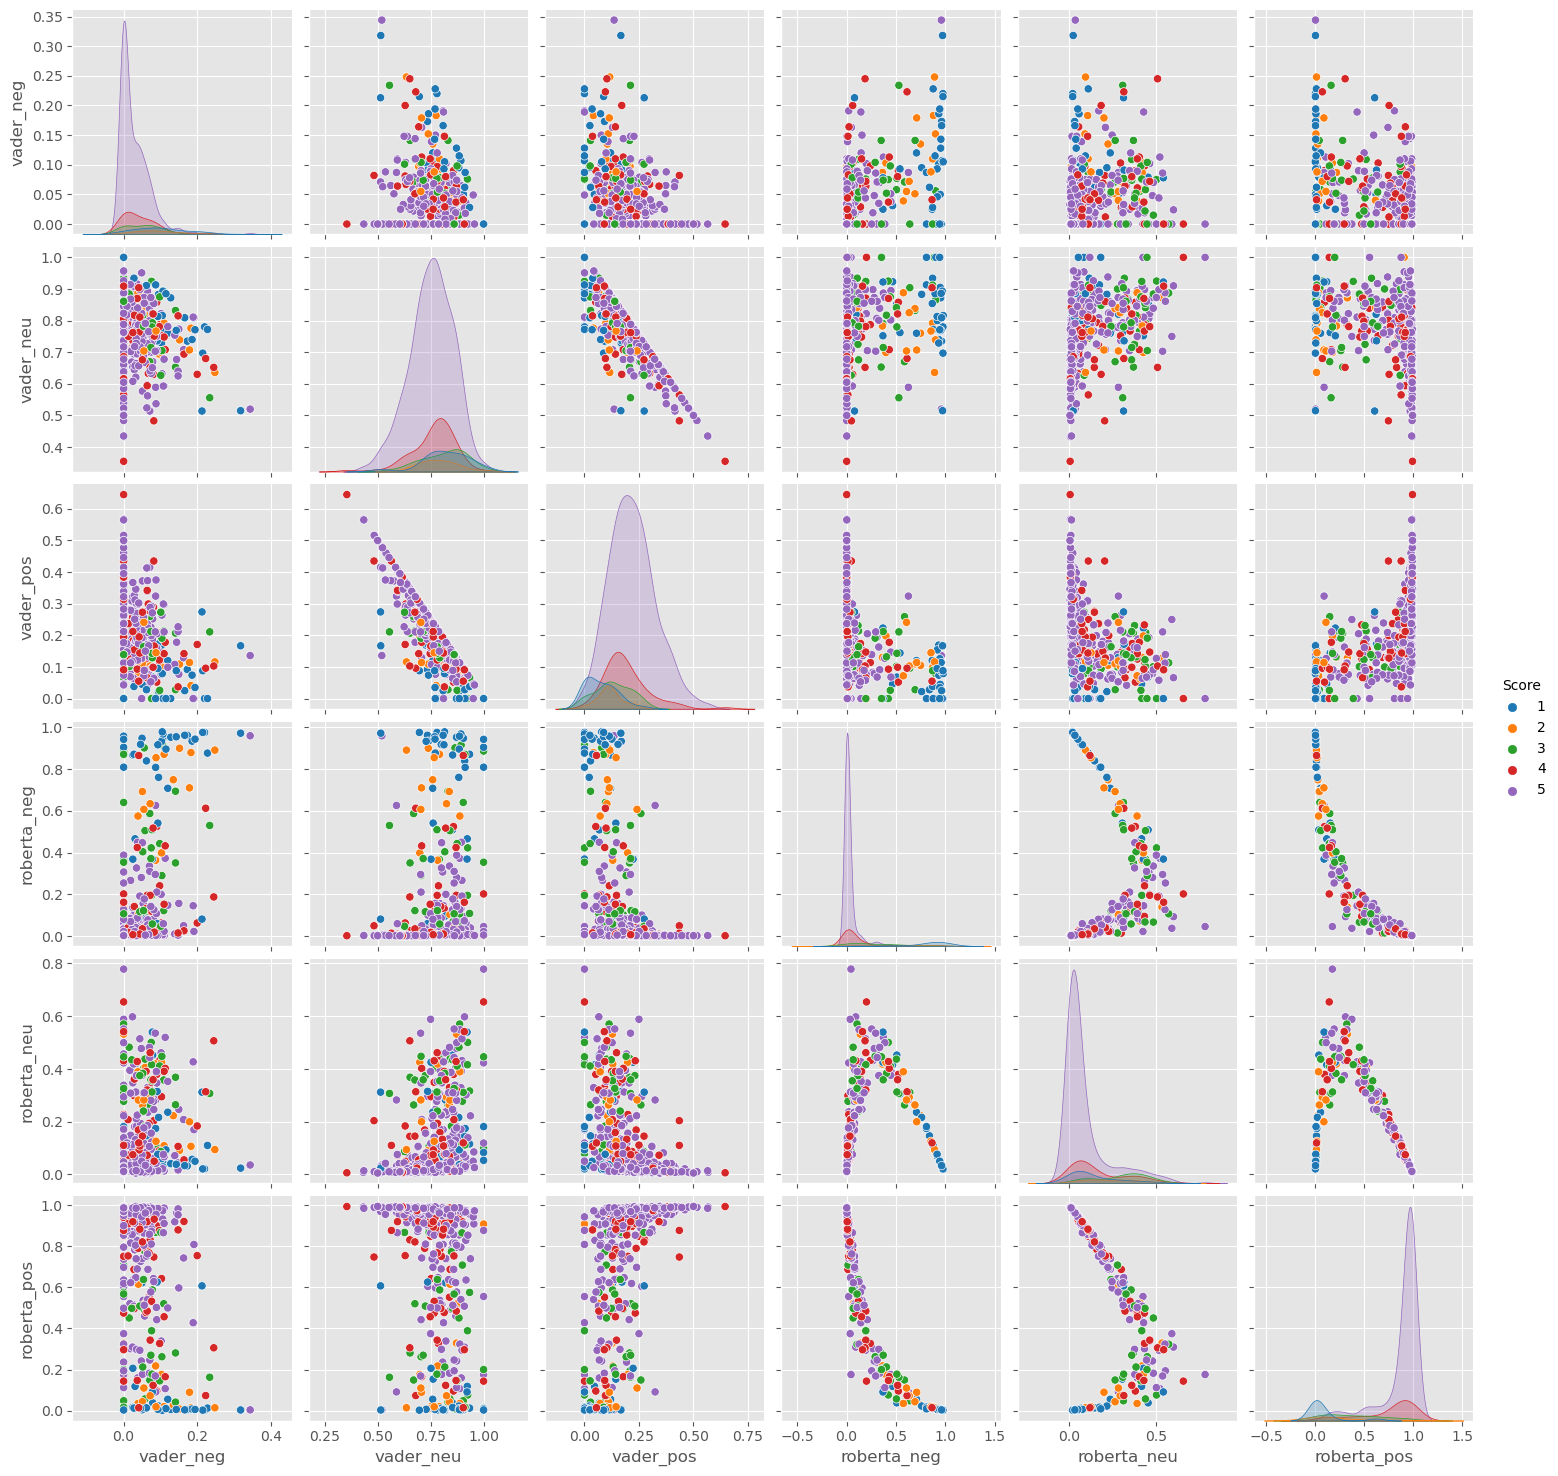

In [37]:
sns.pairplot(data = results_df,
             vars = ['vader_neg', 'vader_neu', 'vader_pos',
            'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue = "Score",
             palette = "tab10"
            )
plt.show()

### Step 4: Review Examples:

* Positive 1-star and Negative 5-Star reviews



In [41]:
# Text said by model to be positive , but actually it's given "1-star"
results_df.query("Score == 1").sort_values("roberta_pos",ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [42]:
# Text said by model to be positive , but actually it's given "1-star"
results_df.query("Score == 1").sort_values("vader_pos",ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [43]:
# Negative Sentiment 5-Star view
results_df.query("Score == 5").sort_values("roberta_pos",ascending = False)['Text'].values[0]

"These are my favorite bars ever. The combo of raisons and dark choc is wonderful! Very filling! These are hard to find in the stores. I'm thankful for subsrcibe and save!"

## The Transformers Pipeline

* Quick and easy way to run sentiment-analysis

In [44]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [48]:
print(sent_pipeline(results_df.query("Score == 5").\
              sort_values("roberta_pos",ascending = False)\
              ['Text'].values[0]))

[{'label': 'POSITIVE', 'score': 0.9998131394386292}]
